# Long-term Influenza Forecasting using Web Data (Code summary)

## Google Trends 데이터 수집

필요한 라이브러리 임포트

pytrends 라이브러리를 사용해 구글 트렌드 데이터를 수집할 예정

In [1]:
from pytrends.request import TrendReq

import pandas as pd
import gensim
import time

Google에서 제공하는 pre-trained word2vec 모델 (load 시 메모리 약 3~4gb 필요)

https://code.google.com/archive/p/word2vec/ 참고

In [2]:
w2v_google = gensim.models.KeyedVectors.load_word2vec_format(
    "./data/GoogleNews-vectors-negative300.bin", binary=True
)

pre-trained 모델의 경우 H1N1을 다양한 방법으로 표현한 단어들이 포함되었고 공백을 "\_"를 사용해 치환했기 때문에 "\_"를 공백으로 다시 치환함

대소문자 중복을 제거하고 n개의 연관 단어를 추출함

In [3]:
flu_related_words = []

# topn 파라미터가 몇 개의 유사 단어를 출력할 지를 정함
for word, sim in w2v_google.most_similar("flu", topn=10):
    word = word.replace("H#N#", "H1N1")
    word = word.replace("h#n#", "H1N1")
    word = word.replace("HIN1", "H1N1")
    word = word.replace("hIn1", "H1N1")
    word = word.replace("HINI", "H1N1")
    word = word.replace("hInI", "H1N1")
    word = word.replace("H1NI", "H1N1")
    word = word.replace("h1nI", "H1N1")
    word = word.replace("_", " ")
    word = word.replace("A/", "")
                        
    # 모두 소문자로 변환하여 저장, 중복인 경우 스킵
    # 실제 제가 실험했을 때는 소문자 변환은 하지 않았고 중복 검사만 했었습니다
    if word not in flu_related_words:
        flu_related_words.append(word.lower())

flu_related_words    

['influenza',
 'h1n1 flu',
 'swine flu',
 'flu',
 'h1n1',
 'seasonal flu',
 'h1n1 virus',
 'flu virus',
 'h1n1 swine flu',
 'h1n1 influenza']

In [4]:
pyt = TrendReq()

google_trends = None

# request의 길이가 제한되어 있기 때문에 한 번에 많은 개수의 키워드를 요청할 수 없습니다.
# 경험적으로 5개 정도가 최대치였기 때문에 키워드를 5개씩 나눠 반복합니다
for i in range(0, len(flu_related_words), 5):
    # timeframe 파라미터가 시작일과 종료일을 의미합니다.
    # 형태는 보시는 바와 같이 공백으로 나눠진 문자열로 나타냅니다
    # geo는 요청 국가를 의미합니다. 한국의 경우 KR
    pyt.build_payload(flu_related_words[i:i+5],
                      timeframe="2020-01-01 2020-12-31",
                      geo="US")
    
    # dataframe을 반환합니다
    sub_df = pyt.interest_over_time()
    
    if google_trends is None:
        google_trends = sub_df.copy()
        # isPartial column이 포함되어 있는데 필요 없기 때문에 drop합니다.
        google_trends = google_trends.drop(["isPartial"], axis=1)
    else:
        google_trends = pd.concat([
            google_trends,
            sub_df.drop(["isPartial"], axis=1)
        ], axis=1)
    
    # 요청이 너무 많을 경우 google에서 ip단위로 일정 시간 요청을 막습니다.
    # 그 때문에 5초 정도의 시간 간격을 두고 요청합니다.
    # 시간 간격이 존재하더라도 너무 많은 요청 시 요청이 막힐 수 있으며
    # 제 경험상으로 다시 요청할 수 있기까지 약 1~2일 정도 소요되었던 것으로 기억합니다.
    time.sleep(5)
google_trends

,influenza,h1n1 flu,swine flu,flu,h1n1,seasonal flu,h1n1 virus,flu virus,h1n1 swine flu,h1n1 influenza
date,,,,,,,,,,
2020-01-05,3,0,0,25,0,0,0,6,0,0
2020-01-12,4,0,0,27,0,0,0,6,0,0
2020-01-19,4,0,0,32,0,0,1,15,0,0
2020-01-26,6,0,1,44,1,1,1,27,1,1
2020-02-02,6,0,1,38,1,1,1,19,0,0
2020-02-09,5,0,0,33,1,1,1,15,0,0
2020-02-16,5,0,0,28,0,0,1,12,0,0
2020-02-23,6,0,1,48,2,2,2,36,1,1
2020-03-01,7,0,3,60,3,3,4,57,3,1


## 시간 차이를 고려한 상관관계 분석

필요 라이브러리를 임포트 합니다.

정규화를 위해 minmax scaler를 사용합니다. [0, 1] 정규화입니다.

In [5]:
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np

미국 CDC에서 수집한 ILI 데이터입니다.

index는 week를 의미하고 column은 year를 의미합니다. 

53주의 경우 제외했습니다.

In [6]:
CDC = pd.read_csv("./data/ILINet_CDC.csv", index_col=0)
CDC = CDC[:52].copy()
CDC

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,19.82840,26.91510,17.67090,49.63680,42.11200,40.78980,19.88590,30.81020,53.57650,36.30950,62.19360
2,18.27490,29.10630,15.43400,46.90720,34.64920,39.37620,19.89850,30.18750,55.24370,31.36430,50.67110
3,19.26060,34.92320,16.47620,47.04730,33.16980,41.50760,21.07100,34.04460,63.45280,33.62130,53.57680
4,19.24950,40.03700,16.84300,41.64600,32.40700,38.78990,21.92560,35.28690,70.18110,38.81150,60.22740
5,20.88770,44.35340,18.63540,36.95330,28.85980,34.57940,23.00140,41.06650,77.80900,45.22350,68.73570
6,20.34340,42.42150,18.64080,32.36300,26.21720,30.63590,26.75740,47.55100,77.69390,52.00910,70.86290
7,19.76490,43.97190,20.18390,28.94210,23.40670,28.26460,30.24270,46.51630,68.11760,54.20340,62.21350
8,19.93620,39.02560,21.03850,27.17420,21.20590,23.59900,31.13280,45.70490,51.57490,52.70780,56.20290
9,18.53830,31.50730,20.95550,25.22970,19.10940,23.34720,33.27880,34.55220,35.59450,45.89910,51.03390
10,18.67300,27.24220,21.03980,25.52270,19.02300,22.12860,35.91800,32.95050,30.05180,43.97140,52.89900


위에서 사용한 데이터 수집 방법을 사용해 1000개의 연관 단어에 대해 데이터를 수집한 결과입니다.

"weeks" column은 year-week 형태입니다.

In [7]:
US_trends = pd.read_csv("./data/US_trends.csv")
US_trends

,influenza,H1N1 flu,swine flu,Flu,H1N1,seasonal flu,H1N1 virus,flu virus,H1N1 swine flu,H1N1 influenza,...,Afluria seasonal flu,hemolytic uremic syndrome HUS,croup,Jeff Duchin,inactivated vaccine,fevers aches,invasive pneumococcal disease,Sudden Acute Respiratory Syndrome,commonly infect humans,weeks
0,0,0,0,6,0,0,0,1,0,0,...,0,0,40,0,46,0,0,0,0,17-35
1,1,0,0,8,0,0,0,2,0,0,...,0,0,50,0,50,14,14,0,0,17-36
2,1,0,0,9,0,0,0,2,0,0,...,0,0,51,0,46,14,14,0,0,17-37
3,1,0,0,11,0,0,0,2,0,0,...,0,0,58,0,87,0,0,0,0,17-38
4,1,0,0,12,0,0,0,2,0,0,...,0,0,68,0,54,14,0,0,0,17-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2,0,1,24,2,3,1,10,1,1,...,0,0,8,1,76,0,0,0,0,20-16
138,2,0,1,19,1,2,1,10,1,1,...,0,0,10,0,41,0,0,0,0,20-17
139,2,0,1,18,1,2,1,8,1,0,...,0,0,5,0,56,0,11,0,0,20-18
140,2,0,1,16,1,2,1,6,1,0,...,0,0,7,0,28,0,0,0,0,20-19


사용할 데이터는 논문에 명시된대로 18년 5주차 부터 20년 20주차 까지 데이터를 사용합니다.

In [8]:
# 상관관계 분석을 위해 2차원으로 표시된 데이터를 1차원으로 축소시킵니다.

CDC_1d = CDC.loc[5:, "2018"].tolist()+CDC.loc[:, "2019"].tolist()+CDC.loc[:20, "2020"].tolist()
CDC_1d = pd.Series(CDC_1d)
CDC_1d

0      77.8090
1      77.6939
2      68.1176
3      51.5749
4      35.5945
        ...   
115    25.7453
116    20.2111
117    16.2086
118    13.5240
119    12.3794
Length: 120, dtype: float64

In [9]:
US_trends[US_trends["weeks"]>="18-05"].reset_index(drop=True)

,influenza,H1N1 flu,swine flu,Flu,H1N1,seasonal flu,H1N1 virus,flu virus,H1N1 swine flu,H1N1 influenza,...,Afluria seasonal flu,hemolytic uremic syndrome HUS,croup,Jeff Duchin,inactivated vaccine,fevers aches,invasive pneumococcal disease,Sudden Acute Respiratory Syndrome,commonly infect humans,weeks
0,5,0,0,60,0,0,0,13,0,0,...,0,0,61,0,26,13,13,0,0,18-05
1,5,0,0,51,0,0,0,11,0,0,...,0,0,62,0,26,18,0,0,0,18-06
2,3,0,0,31,0,0,0,7,0,0,...,0,0,50,0,35,20,13,0,0,18-07
3,2,0,0,20,0,0,0,4,0,0,...,0,0,50,0,43,13,0,0,0,18-08
4,2,0,0,15,0,0,0,4,0,0,...,0,0,48,0,17,13,0,0,0,18-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2,0,1,24,2,3,1,10,1,1,...,0,0,8,1,76,0,0,0,0,20-16
116,2,0,1,19,1,2,1,10,1,1,...,0,0,10,0,41,0,0,0,0,20-17
117,2,0,1,18,1,2,1,8,1,0,...,0,0,5,0,56,0,11,0,0,20-18
118,2,0,1,16,1,2,1,6,1,0,...,0,0,7,0,28,0,0,0,0,20-19


In [10]:
MAX_LAG = 15 # 확인할 최대 시간 차이
US_trends_lag = {}

# 18-05 ~ 20-20 데이터를 사용해 비교할 것입니다.
US_sub_trends = US_trends[US_trends["weeks"]>="18-05"].reset_index(drop=True)

# 마지막 column은 weeks 이므로 제외합니다.
for word in US_trends.columns[:-1]:
    corr_list = []
    for lag in range(MAX_LAG):
        # 0~14까지 한 칸씩 shift해가며 상관관계를 기록합니다.
        corr_list.append(CDC_1d.corr(US_sub_trends[word].shift(lag)))
    US_trends_lag[word] = corr_list
    
US_trends_lag = pd.DataFrame(US_trends_lag)
US_trends_lag

,influenza,H1N1 flu,swine flu,Flu,H1N1,seasonal flu,H1N1 virus,flu virus,H1N1 swine flu,H1N1 influenza,...,polio epidemic,Afluria seasonal flu,hemolytic uremic syndrome HUS,croup,Jeff Duchin,inactivated vaccine,fevers aches,invasive pneumococcal disease,Sudden Acute Respiratory Syndrome,commonly infect humans
0,0.829668,0.336100,0.349430,0.748826,0.364549,0.403529,0.369994,0.524280,0.319033,0.361033,...,0.271124,NaN,-0.142628,0.198686,0.145201,-0.162393,0.040664,0.039938,-0.010277,NaN
1,0.849577,0.345046,0.380504,0.776640,0.394491,0.394467,0.406987,0.555330,0.358868,0.367189,...,0.279193,NaN,-0.150934,0.297012,0.128077,-0.170851,0.056964,0.005441,0.002559,NaN
2,0.851994,0.352069,0.410174,0.778865,0.411469,0.371160,0.433886,0.587392,0.398534,0.357035,...,0.291059,NaN,-0.161638,0.397905,0.159383,-0.179732,0.049596,-0.036410,0.003851,NaN
3,0.804382,0.298711,0.379415,0.728517,0.357998,0.309994,0.389615,0.574788,0.360724,0.312474,...,0.221287,NaN,-0.166509,0.468573,0.220816,-0.154287,0.035815,-0.041899,0.017602,NaN
4,0.713373,0.176797,0.271927,0.630253,0.244313,0.212447,0.280919,0.488458,0.251229,0.247030,...,0.121251,NaN,-0.172783,0.523209,0.219600,-0.130196,0.021969,-0.038412,0.040475,NaN
5,0.609617,0.060213,0.151214,0.529448,0.128806,0.115473,0.160901,0.370703,0.130688,0.161499,...,0.022525,NaN,-0.165132,0.582069,0.223403,-0.098821,0.031806,-0.049313,0.000747,NaN
6,0.502829,-0.029731,0.044381,0.435142,0.038651,0.036168,0.064434,0.252888,0.031161,0.065350,...,-0.037977,NaN,-0.163893,0.657391,0.121017,-0.075309,0.058693,-0.029087,-0.026928,NaN
7,0.411010,-0.069311,-0.023574,0.364562,-0.011318,-0.013416,0.000413,0.166175,-0.031361,-0.026501,...,-0.076505,NaN,-0.159814,0.727201,0.036940,-0.013491,0.057084,-0.022758,-0.035858,NaN
8,0.337216,-0.089261,-0.057713,0.312140,-0.043499,-0.040703,-0.039679,0.106444,-0.063740,-0.076115,...,-0.102812,NaN,-0.157789,0.770343,-0.017352,0.034983,0.070189,-0.019827,-0.013395,NaN
9,0.266749,-0.096702,-0.076806,0.270928,-0.061976,-0.055492,-0.061240,0.063710,-0.074495,-0.103344,...,-0.114869,NaN,-0.145403,0.789349,-0.053077,0.069379,0.068221,-0.034692,-0.027527,NaN


In [11]:
CORR_THRESHOLD = 0.5 # 상관계수의 임계치
LAG_THRESHOLD = 5 # 시간차이의 임계치

US_trends_select = {}

# 단어들 중 최대 상관계수가 0.5가 넘는 단어들만 남깁니다.
over_max = US_trends_lag.max()[US_trends_lag.max()>CORR_THRESHOLD]

for word in over_max.index:
    # 상관계수가 최대일 때의 index가 해당 단어의 최적 시간 차이입니다.
    lag = US_trends_lag[word].argmax()
    corr = US_trends_lag.loc[lag, word]
    
    # 시간 차이가 5일미만인 단어들은 장기간 예측에 사용할 데이터가 적으므로 제외합니다.
    if lag >= LAG_THRESHOLD:
        US_trends_select[word] = {"lag": lag, "corr": corr}
    
US_trends_select

{'whooping cough': {'lag': 11, 'corr': 0.6510106369765208},
 'flu vaccination': {'lag': 14, 'corr': 0.5086254911516204},
 'flu vaccine': {'lag': 14, 'corr': 0.6477487034694918},
 'flu vaccines': {'lag': 14, 'corr': 0.6024075182608302},
 'influenza vaccine': {'lag': 14, 'corr': 0.5518870145477802},
 'stomach bug': {'lag': 6, 'corr': 0.738561687497884},
 'flu mist': {'lag': 14, 'corr': 0.5673332146613024},
 'colds': {'lag': 6, 'corr': 0.852496062522331},
 'nasal vaccine': {'lag': 14, 'corr': 0.5395361699436391},
 'sniffles': {'lag': 12, 'corr': 0.5839769771149144},
 'FluMist': {'lag': 14, 'corr': 0.6035894242446742},
 'vomiting bug': {'lag': 6, 'corr': 0.5982499615806711},
 'Flu shots': {'lag': 14, 'corr': 0.683289011363963},
 'Norovirus bug': {'lag': 6, 'corr': 0.7012055469121398},
 'RSV': {'lag': 7, 'corr': 0.9004149067780595},
 'respiratory syncytial virus': {'lag': 6, 'corr': 0.7109386696085191},
 'FluMist vaccine': {'lag': 14, 'corr': 0.5457856934790213},
 'FluMist nasal vaccine': {

## 데이터 정규화

2010~2020년 데이터를 한번에 묶어서 정규화합니다.

In [12]:
CDC_norm = pd.concat([s for c, s in CDC.items()], ignore_index=True)
CDC_norm = CDC_norm.dropna().values.reshape(-1,1)

CDC_scaler = MinMaxScaler()
CDC_scaler.fit(CDC_norm)
CDC_norm = np.array([CDC_scaler.transform(np.expand_dims(year_val, axis=1)).reshape(-1) for year_val in CDC.values])
CDC_norm = pd.DataFrame(CDC_norm, 
                         columns=CDC.columns,
                         index=CDC.index)
CDC_norm

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,0.187509,0.286816,0.157276,0.605219,0.499773,0.481245,0.188315,0.341399,0.660426,0.418462,0.781179
2,0.165740,0.317522,0.125930,0.566969,0.395195,0.461436,0.188492,0.332673,0.683789,0.349164,0.619713
3,0.179553,0.399035,0.140535,0.568932,0.374464,0.491303,0.204922,0.386723,0.798824,0.380791,0.660431
4,0.179397,0.470696,0.145675,0.493243,0.363775,0.453220,0.216898,0.404132,0.893109,0.453522,0.753626
5,0.202354,0.531182,0.170792,0.427483,0.314068,0.394217,0.231973,0.485122,1.000000,0.543375,0.872855
6,0.194726,0.504110,0.170867,0.363159,0.277037,0.338957,0.284607,0.575990,0.998387,0.638462,0.902663
7,0.186620,0.525836,0.192491,0.315221,0.237653,0.305727,0.333447,0.561491,0.864193,0.669211,0.781458
8,0.189020,0.456523,0.204467,0.290447,0.206813,0.240347,0.345920,0.550121,0.632378,0.648253,0.697231
9,0.169431,0.351168,0.203304,0.263199,0.177434,0.236819,0.375992,0.393836,0.408442,0.552842,0.624797
10,0.171319,0.291400,0.204485,0.267305,0.176223,0.219743,0.412975,0.371391,0.330771,0.525829,0.650933


각 키워드 별로 정규화 합니다.

In [13]:
minmax_scaler = MinMaxScaler()

minmax_scaler.fit(US_trends[[c for c in US_trends.columns if c != 'weeks']])
US_trends_norm = pd.DataFrame(minmax_scaler.transform(US_trends[[c for c in US_trends.columns if c != 'weeks']]),
                              columns=[c for c in US_trends.columns if c != 'weeks'],
                              index=US_trends.index)
US_trends_norm.insert(loc=0, column='weeks', value=US_trends['weeks'])
US_trends_norm

,weeks,influenza,H1N1 flu,swine flu,Flu,H1N1,seasonal flu,H1N1 virus,flu virus,H1N1 swine flu,...,polio epidemic,Afluria seasonal flu,hemolytic uremic syndrome HUS,croup,Jeff Duchin,inactivated vaccine,fevers aches,invasive pneumococcal disease,Sudden Acute Respiratory Syndrome,commonly infect humans
0,17-35,0.0,0.0,0.000000,0.030928,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.043478,0.0,0.0,0.368421,0.0,0.386364,0.000000,0.000000,0.0,0.0
1,17-36,0.1,0.0,0.000000,0.051546,0.000000,0.000000,0.000000,0.010101,0.000000,...,0.000000,0.0,0.0,0.473684,0.0,0.431818,0.500000,0.500000,0.0,0.0
2,17-37,0.1,0.0,0.000000,0.061856,0.000000,0.000000,0.000000,0.010101,0.000000,...,0.000000,0.0,0.0,0.484211,0.0,0.386364,0.500000,0.500000,0.0,0.0
3,17-38,0.1,0.0,0.000000,0.082474,0.000000,0.000000,0.000000,0.010101,0.000000,...,0.000000,0.0,0.0,0.557895,0.0,0.852273,0.000000,0.000000,0.0,0.0
4,17-39,0.1,0.0,0.000000,0.092784,0.000000,0.000000,0.000000,0.010101,0.000000,...,0.000000,0.0,0.0,0.663158,0.0,0.477273,0.500000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,20-16,0.2,0.0,0.076923,0.216495,0.133333,0.428571,0.058824,0.090909,0.071429,...,0.217391,0.0,0.0,0.031579,1.0,0.727273,0.000000,0.000000,0.0,0.0
138,20-17,0.2,0.0,0.076923,0.164948,0.066667,0.285714,0.058824,0.090909,0.071429,...,0.347826,0.0,0.0,0.052632,0.0,0.329545,0.000000,0.000000,0.0,0.0
139,20-18,0.2,0.0,0.076923,0.154639,0.066667,0.285714,0.058824,0.070707,0.071429,...,0.260870,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.392857,0.0,0.0
140,20-19,0.2,0.0,0.076923,0.134021,0.066667,0.285714,0.058824,0.050505,0.071429,...,0.304348,0.0,0.0,0.021053,0.0,0.181818,0.000000,0.000000,0.0,0.0


## 데이터 슬라이싱

1) truth는 학습에 사용할 정답 데이터(label)
2) enc1_inp는 과거 ILI데이터
    - 현재 시점기준으로 이전 8주의 데이터 사용
    - 2011~2017년의 동일한 8주 데이터도 같이 사용
    - 예) 예측 시점이 19년 10주인 경우 19년 1~9주 데이터 + 11~17년 1~9주 데이터도 같이 사용
3) enc2_inp는 시간 차이를 고려한 웹 데이터
    - 각 웹 데이터(키워드)별로 시간 차이가 다 다름
    - 각 시간 차이를 고려하여 시간 차이 이전의 데이터를 사용
    - 예) 예측 시점이 19년 10주이고, 시간 차이가 5주인 경우 18년 49주~19년 4주 데이터 사용
4) dec_inp는 시간 차이를 고려한 웹 데이터의 미래 추정치
    - 시간 차이 이후의 데이터 사용
    - 예) 예측 시점이 19년 10주이고, 시간 차이가 5주인 경우 19년 5주~9주 데이터 사용
    - 만약 예측 스텝보다 시간 차이가 적은 경우, 아주 작은 값으로 나머지를 채움
    
아래 이미지는 look-back이 5, look-ahead가 4일 때 데이터의 구조를 그림으로 간단히 표현한 것입니다.

<img src="./data/data_slice.png"/>


짧게 설명하기가 어렵습니다. 그 때문에 코드도 복잡합니다. 이해 안되는 부분은 따로 질문해주시면 답변드리겠습니다.

In [14]:
def make_dataset(flu_data, web_data, year_weeks, lag_info, look_back, look_ahead):
    MAX_WEEK = 52
    
    # 라벨 데이터 
    def _truth(year, week):
        # 연도가 넘어갈 경우 처리
        if week+look_ahead-1>MAX_WEEK:
            truth = pd.concat([
                flu_data.loc[week:, "20"+str(year)],
                flu_data.loc[1:look_ahead-MAX_WEEK+week-1, "20"+str(year+1)]
            ])
        else:
            truth = flu_data.loc[week:week+look_ahead-1, "20"+str(year)]
        return truth.values.reshape(-1, 1)
    
    # 인코더1 데이터
    def _encoder1(year, week):
        # 연도가 넘어갈 경우 처리
        if week > look_back:
            enc1_inp = pd.concat([
                flu_data.loc[week-look_back:week-1, [str(y) for y in range(2011, 2017)]],
                flu_data.loc[week-look_back:week-1, "20"+str(year)]
            ], axis=1)
        else:
            sub1 = flu_data.loc[:week-1, [str(y) for y in range(2011, 2017)]]
            sub1.columns = [str(y) for y in range(2010, 2016)]
            sub1 = pd.concat([
                flu_data.loc[MAX_WEEK-look_back+week:, [str(y) for y in range(2010, 2016)]],
                sub1
            ])
            
            sub2 = flu_data.loc[:week-1, "20"+str(year)]
            sub2.columns = [["20"+str(year-1)]]
            sub2 = pd.concat([
                flu_data.loc[MAX_WEEK-look_back+week:, "20"+str(year-1)],
                sub2
            ])
            
            enc1_inp = pd.concat([sub1, sub2], axis=1)
        return enc1_inp.values
    
    # 인코더2 데이터
    def _encoder2(year, week):
        enc2_inp = []
        pos = web_data[web_data["weeks"]==f"{year}-{week:02d}"].index[0]
        for word in lag_info:
            lag = lag_info[word]["lag"]
            # 현재 위치에서 look-back만큼 뒤로가는데
            # 거기서 시간차이만큼 더 뒤로감
            start_pos = pos-lag-look_back 
            end_pos = start_pos+look_back-1
            
            enc2_inp.append(web_data.loc[start_pos:end_pos, word].tolist())
            
        return np.array(enc2_inp).T
    
    # 디코더 데이터
    def _decoder(year, week):
        # 연도가 넘어갈 경우 처리
        if week > 1:
            truth = _truth(year, week-1)
        else:
            truth = _truth(year-1, MAX_WEEK)
            
        dec_inp = []
        pos = web_data[web_data["weeks"]==f"{year}-{week:02d}"].index[0]
        for word in lag_info:
            lag = lag_info[word]["lag"]
            # 시간 차이 ~ 현재 시점의 데이터를 미래 추정치로 사용
            # 미래 추정치의 길이가 예측하려는 기간보다 짧은 경우
            # 아주 작은 값들로 채움 (모델의 입력 형태를 맞추기 위해)
            start_pos = pos-lag
            end_pos = start_pos+look_ahead-1 if lag >= look_ahead else pos
            
            targ_inp = web_data.loc[start_pos:end_pos, word].tolist()
            while len(targ_inp) != look_ahead:
                targ_inp.append(np.random.uniform(1e-6, 1e-4))
            dec_inp.append(targ_inp)
            
        dec_inp = np.array(dec_inp).T
        dec_inp = np.concatenate([truth, dec_inp], axis=-1)
        
        return dec_inp
            
    truth = []
    enc1_inp = []
    enc2_inp = []
    dec_inp = []
    for year_week in year_weeks[look_back:-look_ahead]:
        year, week = year_week.split("-")
        year, week = int(year), int(week)
        
        truth.append(_truth(year, week))
        enc1_inp.append(_encoder1(year, week))
        enc2_inp.append(_encoder2(year, week))
        dec_inp.append(_decoder(year, week))
        
    truth = np.array(truth)    
    enc1_inp = np.array(enc1_inp)
    enc2_inp = np.array(enc2_inp)
    dec_inp = np.array(dec_inp)
    
    return truth, enc1_inp, enc2_inp, dec_inp

In [15]:
truth, enc1_inp, enc2_inp, dec_inp = make_dataset(CDC_norm, US_trends_norm, 
                                                 US_sub_trends["weeks"].values, US_trends_select, 
                                                 look_back=8, look_ahead=10)

truth.shape, enc1_inp.shape, enc2_inp.shape, dec_inp.shape

((102, 10, 1), (102, 8, 7), (102, 8, 29), (102, 10, 30))

## 모델 설계

"model"은 학습을 위한 모델이고

"encoder_model", "decoder_model"은 예측을 위한 모델입니다.

In [16]:
import tensorflow as tf

In [17]:
class MultiEncoder():
    def __init__(self, units, look_back, look_ahead, 
                 num_enc1_feature=7, num_enc2_feature=1, num_dec_feature=1):
        enc1_inputs = tf.keras.Input(shape=(look_back, num_enc1_feature))
        enc1_lstm = tf.keras.layers.LSTM(units, 
                                         return_state=True,
                                         return_sequences=True)
        
        enc2_inputs = tf.keras.Input(shape=(look_back, num_enc2_feature))
        enc2_lstm = tf.keras.layers.LSTM(units,
                                         return_state=True,
                                         return_sequences=True)
        
        dec_inputs = tf.keras.Input(shape=(None, num_dec_feature))
        dec_lstm = tf.keras.layers.LSTM(units*2,
                                        return_state=True,
                                        return_sequences=True)
        dec_attn = tf.keras.layers.Attention()
        
        dec_dense1 = tf.keras.layers.Dense(units)
        dec_dense2 = tf.keras.layers.Dense(1)
        leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)
        
        enc1_outputs, *enc1_states = enc1_lstm(enc1_inputs)
        enc2_outputs, *enc2_states = enc2_lstm(enc2_inputs)
        
        enc_outputs = tf.concat([enc1_outputs, enc2_outputs], axis=-1)
        enc_states = [
            tf.concat([enc1_states[0], enc2_states[0]], axis=-1),
            tf.concat([enc1_states[1], enc2_states[1]], axis=-1)
        ]
        
        dec_outputs, *dec_states = dec_lstm(dec_inputs, initial_state=enc_states)
        dec_outputs = dec_attn([dec_outputs, enc_outputs])
        outputs = dec_dense1(dec_outputs)
        outputs = dec_dense2(outputs)
        outputs = leaky_relu(outputs)
        
        model = tf.keras.Model([enc1_inputs, enc2_inputs, dec_inputs], outputs)
        model.compile(optimizer="adam", loss="mse")
        self.model = model
        
        dec_state_inputs = [
            tf.keras.Input(shape=(units*2,)),
            tf.keras.Input(shape=(units*2,))
        ]
        
        dec_encoder_inputs = tf.keras.Input(shape=(look_back, units*2))
        dec_outputs2, *dec_states2 = dec_lstm(dec_inputs, initial_state=dec_state_inputs)
        dec_outputs2 = dec_attn([dec_outputs2, dec_encoder_inputs])
        outputs2 = dec_dense1(dec_outputs2)
        outputs2 = dec_dense2(outputs2)
        outputs2 = leaky_relu(outputs2)
        
        self.encoder_model = tf.keras.Model([enc1_inputs, enc2_inputs], [enc_outputs, enc_states])
        self.decoder_model = tf.keras.Model([dec_inputs, dec_encoder_inputs, dec_state_inputs],
                                            [outputs2, dec_states2])        

In [18]:
tf.keras.backend.clear_session()

multi_encoder = MultiEncoder(128, 8, 10, 
                             num_enc1_feature=7, num_enc2_feature=29, num_dec_feature=30)

In [19]:
# model 입출력 테스트

multi_encoder.model([
    tf.random.uniform((32, 8, 7)),
    tf.random.uniform((32, 8, 29)),
    tf.random.uniform((32, 10, 30)),
]).shape

TensorShape([32, 10, 1])

In [20]:
# encoder_model 입출력 테스트

sample_enc_outputs, sample_enc_states = multi_encoder.encoder_model([
                                                            tf.random.uniform((32, 8, 7)),
                                                            tf.random.uniform((32, 8, 29)),
                                                        ])
sample_enc_outputs.shape, sample_enc_states[0].shape, sample_enc_states[1].shape

(TensorShape([32, 8, 256]), TensorShape([32, 256]), TensorShape([32, 256]))

In [21]:
# decoder_model 입출력 테스트

sample_dec_outputs, sample_dec_states = multi_encoder.decoder_model([
                                                        tf.random.uniform((32, 1, 30)),
                                                        sample_enc_outputs,
                                                        sample_enc_states
                                                    ])
sample_dec_outputs.shape, sample_dec_states[0].shape, sample_dec_states[1].shape

(TensorShape([32, 1, 1]), TensorShape([32, 256]), TensorShape([32, 256]))

## 모델 학습

In [22]:
from matplotlib import pyplot as plt

In [23]:
# 학습

history = multi_encoder.model.fit([enc1_inp, enc2_inp, dec_inp], truth,
                                  epochs=200, batch_size=64, validation_split=0.2)

Epoch 1/200
2/2 [==============================] - 6s 2s/step - loss: 0.0531 - val_loss: 0.2282
Epoch 2/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0234 - val_loss: 0.1551
Epoch 3/200
2/2 [==============================] - 0s 47ms/step - loss: 0.0207 - val_loss: 0.2196
Epoch 4/200
2/2 [==============================] - 0s 47ms/step - loss: 0.0152 - val_loss: 0.2096
Epoch 5/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0114 - val_loss: 0.1409
Epoch 6/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0112 - val_loss: 0.1997
Epoch 7/200
2/2 [==============================] - 0s 47ms/step - loss: 0.0093 - val_loss: 0.1535
Epoch 8/200
2/2 [==============================] - 0s 47ms/step - loss: 0.0082 - val_loss: 0.1749
Epoch 9/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0073 - val_loss: 0.1537
Epoch 10/200
2/2 [==============================] - 0s 47ms/step - loss: 0.0064 - val_loss: 0.1531
Epoch 11/200
2/2 [===

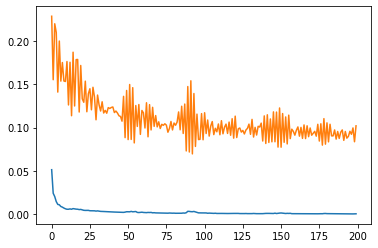

In [24]:
# 학습 결과

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

## 모델 예측

In [25]:
# encoder로부터 output과 state를 얻습니다
enc_outputs, enc_states = multi_encoder.encoder_model([enc1_inp, enc2_inp])

# 학습 과정과 달리 예측 값을 받아 다시 예측할 것이므로 
# 첫 번째 값만 실제 값을 사용합니다.
sub_dec_inp = dec_inp[:, :1, :] # (batch, 1, feature_num)

prds = None

# 10주 예측을 위해 10번 반복합니다.
for step in range(10):
    prd, states = multi_encoder.decoder_model([sub_dec_inp, enc_outputs, enc_states])
    if prds is None:
        prds = prd
    else:
        # 예측 값을 이어붙입니다.
        prds = tf.concat([prds, prd], axis=1)
        
    if step != 10-1:
        # 입력으로 예측 값을 다시 사용합니다.
        sub_dec_inp = dec_inp[:, step+1:step+2, :]
        sub_dec_inp[:, :, 0] = prd[:, 0]
        enc_states = states

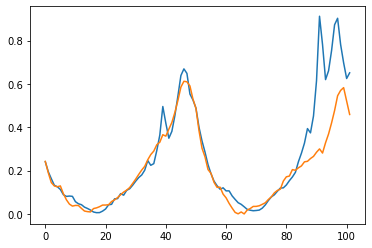

In [26]:
plt.plot(truth[:, 0])
plt.plot(prds[:, 0])
plt.show()

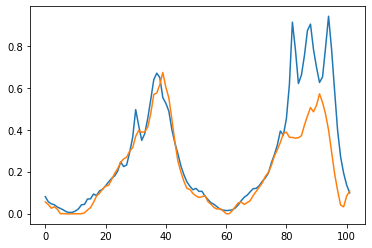

In [27]:
plt.plot(truth[:, 9])
plt.plot(prds[:, 9])
plt.show()